In [1]:
! pip install talib-binary
! gdown 17OYeD6dlfwX28FNoUpqXkLVpzjUtTCRW
! unzip /content/ThaiDepression.zip
! pip install -qqq greykite
! pip install --upgrade pandas
! python -m pip uninstall matplotlib
! pip install matplotlib==3.1.3
! pip install tsai
! pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 33.2 MB/s 
Downloading...
From: https://drive.google.com/uc?id=17OYeD6dlfwX28FNoUpqXkLVpzjUtTCRW
To: /content/ThaiDepression.zip
100% 8.78M/8.78M [00:00<00:00, 128MB/s]
Archive:  /content/ThaiDepression.zip
   creating: ThaiDepression/2016/
  inflating: ThaiDepression/2016/ahb-2016-10.csv  
  inflating: ThaiDepression/2016/ahb-2016-10.pdf  
  inflating: ThaiDepression/2016/ahb-2016-11.csv  
  inflating: ThaiDepression/2016/ahb-2016-11.pdf  
  inflating: ThaiDepression/2016/ahb-2016-12.csv  
  inflating: ThaiDepression/2016/ahb-2016-12.pdf  
   creating: ThaiDepression/2017/
  inflating: ThaiDepression/2017/ahb-2017-01.csv  
  inflating: ThaiDepression/2017/ahb-2017-01.pdf  
  inflating: ThaiDepression/2017/ahb-2017-02.csv  
  inflating: ThaiDepression/2017/ahb-2017-02.pdf  
  inflating: ThaiDepression/2017/ahb-2017-03.csv  
  inflating: ThaiD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 29.6 MB/s 
     |████████████████████████████████| 2.5 MB 68.2 MB/s 
     |████████████████████████████████| 750.6 MB 9.9 kB/s 
     |████████████████████████████████| 19.1 MB 69.7 MB/s 
     |████████████████████████████████| 19.1 MB 789 kB/s 
     |████████████████████████████████| 21.0 MB 263 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import talib
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster 
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
import plotly
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tsai.all import *
from tsai.inference import load_learner
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from pmdarima import arima
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.utils.plotting import plot_series
import seaborn as sns
from sklearn import preprocessing
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import math
from sklearn.impute import SimpleImputer
import torch
from sklearn.model_selection import TimeSeriesSplit
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


#Data Preparation

In [3]:
path = "/content/ThaiDepression/"
year_list = os.listdir(path)
year_list.sort()

df_list = []
name_list = []
 
for i in range(len(year_list)):
    file_list = os.listdir(path+year_list[i])
    file_list.sort()
    for f in file_list:
        if '.csv' in f:
            # print(f)
            name_list.append(f[4:11])
            df_list.append(pd.read_csv(path+year_list[i]+'/'+f, header=None, index_col=False))


finished_process = []
for i in range(len(df_list[0])):
    finished_process.append(pd.DataFrame(df_list[0].iloc[i,:]).T.reset_index(drop=True))
    finished_process[i]['y-m'] = name_list[0]


i=1
while(i != len(df_list)):
    # print('i=' + str(i))
    if len(df_list[i]) == 89:
        insert = { 0 : np.nan, 1 : np.nan, 2 : np.nan, 3 : np.nan, 4 : np.nan, 5 : np.nan, 6 :np.nan, 7 : np.nan, 8 : np.nan, 9 : np.nan, 'y-m' : name_list[i]}
        finished_process[89] = pd.concat([finished_process[89], pd.DataFrame(insert, index=[0])], ignore_index = True)
    for j in range(len(df_list[i])):
        # print('j=' + str(j))
        if len(df_list[i].columns) == 6 :
            insert = { 0 : df_list[i].iloc[j,0], 1 : df_list[i].iloc[j,1], 2 : np.nan, 3 : df_list[i].iloc[j,2], 4 : df_list[i].iloc[j,3], 5 : np.nan, 6 :np.nan, 7 : df_list[i].iloc[j,4], 8 : np.nan, 9 : df_list[i].iloc[j,5], 'y-m' : name_list[i]}
            finished_process[j] = pd.concat([finished_process[j], pd.DataFrame(insert, index=[0])], ignore_index = True)
        else:
            finished_process[j] = pd.concat([finished_process[j], pd.DataFrame(df_list[i].iloc[j,:]).T.reset_index(drop=True)], ignore_index = True)
            finished_process[j]['y-m'][i] = name_list[i]
    i=i+1


for i in range(len(finished_process)):
    finished_process[i].index = finished_process[i]['y-m'].values
    finished_process[i].drop(['y-m'], axis=1, inplace=True)
    # finished_process[i].index = pd.to_datetime(finished_process[i].index, format='%Y-%m')
    finished_process[i] = finished_process[i].replace(',','', regex=True)  
    finished_process[i] = finished_process[i].apply(pd.to_numeric)

    # pct_change(1) = (value on this index - value on previous index) / value on previous index

    finished_process[i]['0_pct_change'] = finished_process[i][0].pct_change(1)
    finished_process[i]['1_pct_change'] = finished_process[i][1].pct_change(1)
    finished_process[i]['2_pct_change'] = finished_process[i][2].pct_change(1)
    finished_process[i]['3_pct_change'] = finished_process[i][3].pct_change(1)
    finished_process[i]['4_pct_change'] = finished_process[i][4].pct_change(1)
    finished_process[i]['5_pct_change'] = finished_process[i][5].pct_change(1)
    finished_process[i]['6_pct_change'] = finished_process[i][6].pct_change(1)
    finished_process[i]['7_pct_change'] = finished_process[i][7].pct_change(1)
    finished_process[i]['8_pct_change'] = finished_process[i][8].pct_change(1)
    finished_process[i]['9_pct_change'] = finished_process[i][9].pct_change(1)
    # finished_process[i].loc[finished_process[i][3] == np.nan, '3_pct_change'] = np.nan
    # finished_process[i]['3_pct_change'] = finished_process[i][3].apply(lambda x: np.nan if x == np.nan else x)

In [4]:
AHB_data = []
AHB_list = [9, 15, 21, 30, 39, 48, 53, 61, 66, 72, 80, 88]
province_AHB_list = [
            [0, 1, 2, 3, 4, 5, 6, 7, 8],
            [0, 10, 11, 12, 13, 14],
            [0, 16, 17, 18, 19, 20],
            [0, 22, 23, 24, 25, 26, 27, 28, 29],
            [0, 31, 32, 33, 34, 35, 36, 37, 38],
            [0, 40, 41, 42, 43, 44, 45, 46, 47],
            [0, 49, 50, 51, 52],
            [0, 54, 55, 56, 57, 58, 59, 60],
            [0, 62, 63, 64, 65],
            [0, 67, 68, 69, 70, 71],
            [0, 73, 74, 75, 76, 77, 78, 79],
            [0, 81, 82, 83, 84, 85, 86, 87]
            ]
# AHB
for j in range(len(AHB_list)):
    AHB = pd.DataFrame(finished_process[AHB_list[j]][3].values, columns=['AHB_'+str(j+1)])
    for i in range(len(province_AHB_list[j])):
        if i == 0:
            continue
        AHB = pd.concat([AHB, finished_process[province_AHB_list[j][i]][3].reset_index(drop='index')], axis = 1)
    temp = [str(x) for x in province_AHB_list[j]]
    temp[0] = 'AHB_'+str(j+1)
    AHB.columns = temp
    AHB['y'] = AHB['AHB_'+str(j+1)].shift(-1)
    AHB.index = finished_process[9][3].index
    AHB.drop(AHB.tail(1).index,inplace=True)
    AHB_data.append(AHB)


normalized_AHB_data = []
for i in range(len(AHB_data)):
    temp = (AHB_data[i]-AHB_data[i].mean())/AHB_data[i].std()
    # temp = (AHB_data[i]-AHB_data[i].min())/(AHB_data[i].max()-AHB_data[i].min())
    normalized_AHB_data.append(temp)

In [ ]:
AHB_data

[          AHB_1      1     2      3     4      5     6      7      8         y
 2016-10   53656  10383  5315   4266  4057  15408  2002   9011   3214   53653.0
 2016-11   53653  10383  5315   4265  4057  15406  2002   9011   3214   53650.0
 2016-12   53650  10382  5315   4265  4057  15404  2002   9011   3214   53978.0
 2017-01   53978  10382  5655   4265  4057  15393  2002   9011   3213   53976.0
 2017-02   53976  10382  5655   4264  4057  15392  2002   9011   3213   57981.0
 ...         ...    ...   ...    ...   ...    ...   ...    ...    ...       ...
 2022-02  137049  25005  9671  10674  7947  47073  6876  17426  12377  137869.0
 2022-03  137869  25223  9711  10788  7988  47292  6924  17444  12499  139544.0
 2022-04  139544  25456  9781  10932  8095  48020  7004  17606  12650  140152.0
 2022-05  140152  25619  9833  10977  8122  48155  7026  17703  12717  141246.0
 2022-06  141246  25836  9884  11069  8161  48616  7090  17783  12807  142732.0
 
 [69 rows x 10 columns],
          AHB

In [ ]:
normalized_AHB_data

[            AHB_1         1         2         3         4         5         6  \
 2016-10 -1.490884 -1.623813 -1.951334 -1.522971 -1.581404 -1.453067 -1.351134   
 2016-11 -1.490988 -1.623813 -1.951334 -1.523419 -1.581404 -1.453242 -1.351134   
 2016-12 -1.491092 -1.624026 -1.951334 -1.523419 -1.581404 -1.453417 -1.351134   
 2017-01 -1.479695 -1.624026 -1.686370 -1.523419 -1.581404 -1.454378 -1.351134   
 2017-02 -1.479764 -1.624026 -1.686370 -1.523867 -1.581404 -1.454466 -1.351134   
 ...           ...       ...       ...       ...       ...       ...       ...   
 2022-02  1.406832  1.496236  1.443318  1.346758  1.294489  1.314361  1.327021   
 2022-03  1.435325  1.542753  1.474490  1.397811  1.324801  1.333501  1.353396   
 2022-04  1.493528  1.592470  1.529041  1.462300  1.403906  1.397126  1.397354   
 2022-05  1.514654  1.627251  1.569565  1.482452  1.423868  1.408924  1.409442   
 2022-06  1.552668  1.673555  1.609310  1.523653  1.452701  1.449214  1.444609   
 
              

#Deep Learning

In [5]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [7]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [8]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [9]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            #if (epoch <= 10) | (epoch % 50 == 0):
            #    print(
            #        f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
            #    )

        #torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [11]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler2.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    # df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

PROGRESS: [ 1 / 1 ]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] VALIDATE: [18] TEST: [19 20 21 22 23]


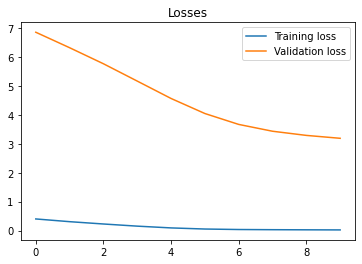

MAE: 3.114059
MSE: 9.713846
RMSE: 3.1167045
MAPE: 1.0718973
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] VALIDATE: [23] TEST: [24 25 26 27 28]


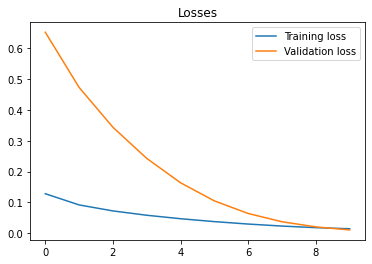

MAE: 0.09290538
MSE: 0.008643469
RMSE: 0.09297026
MAPE: 0.08924
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] VALIDATE: [28] TEST: [29 30 31 32 33]


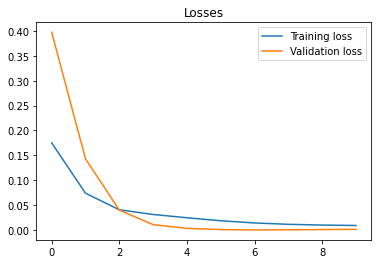

MAE: 0.06231184
MSE: 0.005091198
RMSE: 0.07135263
MAPE: 0.059395075
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] VALIDATE: [33] TEST: [34 35 36 37 38]


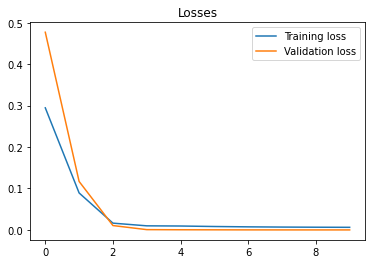

MAE: 0.15472679
MSE: 0.030784503
RMSE: 0.17545512
MAPE: 0.116896585
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37] VALIDATE: [38] TEST: [39 40 41 42 43]


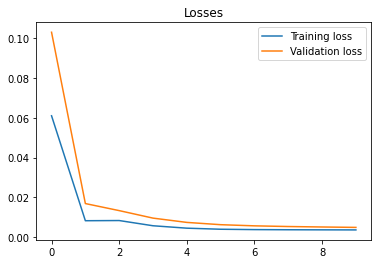

MAE: 0.09790392
MSE: 0.013477383
RMSE: 0.11609213
MAPE: 0.08878731
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] VALIDATE: [43] TEST: [44 45 46 47 48]


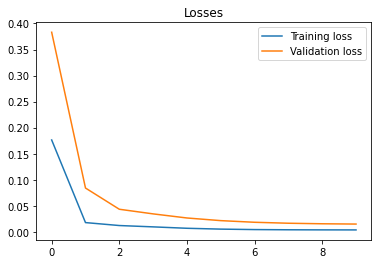

MAE: 0.09656622
MSE: 0.009401154
RMSE: 0.096959546
MAPE: 0.08134543
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] VALIDATE: [48] TEST: [49 50 51 52 53]


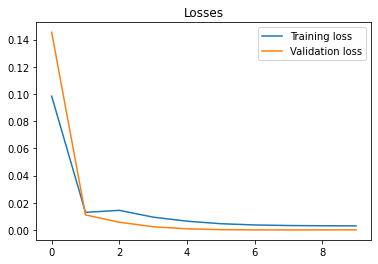

MAE: 0.006514835
MSE: 5.264981e-05
RMSE: 0.007256019
MAPE: 0.006074093
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] VALIDATE: [53] TEST: [54 55 56 57 58]


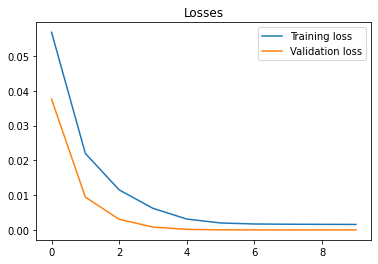

MAE: 0.0068359612
MSE: 5.5343367e-05
RMSE: 0.0074393125
MAPE: 0.00646239
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57] VALIDATE: [58] TEST: [59 60 61 62 63]


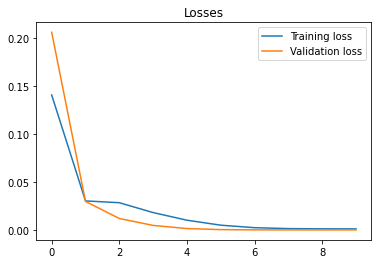

MAE: 0.008353424
MSE: 7.8500176e-05
RMSE: 0.008860032
MAPE: 0.007861774
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62] VALIDATE: [63] TEST: [64 65 66 67 68]


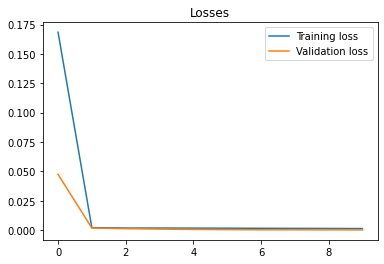

MAE: 0.017720843
MSE: 0.0003544467
RMSE: 0.018826755
MAPE: 0.01673919
{
  "AHB_number": 0,
  "validate_size": 1,
  "test_size": 5,
  "n_splits": 10,
  "hidden_dim": 16,
  "layer_dim": 1,
  "dropout": 0.2,
  "n_epochs": 10,
  "model": "gru",
  "MAE": 0.36578981871716676,
  "MSE": 0.9781784852933925,
  "RMSE": 0.37119162725284693,
  "MAPE": 0.1544699115678668
}


In [66]:
AHB_numbers = [0] # q
validate_sizes = [1] # i
test_sizes = [5] # j 
n_splitss = [10] # k
hidden_dims = [16] # l
layer_dims = [1] # m
dropouts = [0.2] # n
n_epochss = [10] # o
models = ['gru'] # p


count = 1
performance_json = []
for q in range(len(AHB_numbers)):
    for i in range(len(validate_sizes)):
        for j in range(len(test_sizes)):
            for k in range(len(n_splitss)):
                for l in range(len(hidden_dims)):
                    for m in range(len(layer_dims)):
                        for n in range(len(dropouts)):
                            for o in range(len(n_epochss)):
                                for p in range(len(models)):

                                    mae = 0
                                    mse = 0
                                    rmse = 0
                                    mape = 0

                                    print('PROGRESS: [ ' + str(count) + ' / ' + str(len(AHB_numbers)*len(validate_sizes)*len(test_sizes)*len(n_splitss)*len(hidden_dims)*len(layer_dims)*len(dropouts)*len(n_epochss)*len(models)) +' ]')
                                    %matplotlib inline
                                    #df_train_valid = AHB_data[AHB_numbers[q]][:60]
                                    #df_test = AHB_data[AHB_numbers[q]][60:]

                                    #X_test = df_test.drop(['y'], axis=1)
                                    #y_test = df_test.drop(df_train_valid.columns.difference(['y']), axis=1)

                                    X = AHB_data[AHB_numbers[q]].drop(['y','AHB_'+str(AHB_numbers[q]+1)], axis=1)
                                    y = AHB_data[AHB_numbers[q]].drop(AHB_data[AHB_numbers[q]].columns.difference(['y']), axis=1) 
                                    tscv = TimeSeriesSplit(n_splits=n_splitss[k], test_size=test_sizes[j])
                                    for train_index, test_index in tscv.split(X):
                                        #print("TRAIN:", train_index[:test_index[0]-validate_sizes[i]], "VALIDATE:", np.array(range(test_index[0]-validate_sizes[i],test_index[0])), "TEST:", test_index)
                                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                                        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                                        X_val = pd.DataFrame(X_train.tail(validate_sizes[i]))
                                        X_train = X_train.drop(X_train.tail(validate_sizes[i]).index)
                                        y_val = pd.DataFrame(y_train.tail(validate_sizes[i]))
                                        y_train = y_train.drop(y_train.tail(validate_sizes[i]).index)



                                        scaler = get_scaler('minmax')
                                        scaler2 = get_scaler('minmax')

                                        X_train_arr = scaler.fit_transform(X_train)
                                        X_val_arr = scaler.transform(X_val)

                                        y_train_arr = scaler2.fit_transform(y_train)
                                        y_val_arr = scaler2.transform(y_val)



                                        from torch.utils.data import TensorDataset, DataLoader
                                        import torch


                                        train_features = torch.Tensor(X_train_arr)
                                        train_targets = torch.Tensor(y_train_arr)
                                        val_features = torch.Tensor(X_val_arr)
                                        val_targets = torch.Tensor(y_val_arr)

                                        train = TensorDataset(train_features, train_targets)
                                        val = TensorDataset(val_features, val_targets)


                                        import torch.optim as optim

                                        input_dim = len(X.columns)
                                        output_dim = 1
                                        hidden_dim = hidden_dims[l]
                                        layer_dim = layer_dims[m]
                                        batch_size = 1
                                        dropout = dropouts[n]
                                        n_epochs = n_epochss[o]
                                        learning_rate = 1e-3
                                        weight_decay = 1e-6

                                        model_params = {'input_dim': input_dim,
                                                        'hidden_dim' : hidden_dim,
                                                        'layer_dim' : layer_dim,
                                                        'output_dim' : output_dim,
                                                        'dropout_prob' : dropout}

                                        model = get_model(models[p], model_params)

                                        loss_fn = nn.MSELoss(reduction="mean")
                                        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

                                        train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
                                        val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

                                        opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
                                        opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
                                        #opt.plot_losses()

                                        X_test_arr = scaler.transform(X_test)
                                        y_test_arr = scaler2.transform(y_test)

                                        test_features = torch.Tensor(X_test_arr)
                                        test_targets = torch.Tensor(y_test_arr)

                                        test = TensorDataset(test_features, test_targets)

                                        test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
                                        test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)


                                        predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
                                        df_result = format_predictions(predictions, values, X_test, scaler)

                                        mae = mae + mean_absolute_error(df_result.value, df_result.prediction)
                                        mse = mse + mean_squared_error(df_result.value, df_result.prediction)
                                        rmse = rmse + mean_squared_error(df_result.value, df_result.prediction, squared = False)
                                        mape = mape +  mean_absolute_percentage_error(df_result.value, df_result.prediction)
                                        #print('MAE: ' + str(mean_absolute_error(df_result.value, df_result.prediction)))
                                        #print('MSE: ' + str(mean_squared_error(df_result.value, df_result.prediction)))
                                        #print('RMSE: ' + str(mean_squared_error(df_result.value, df_result.prediction, squared = False)))
                                        #print('MAPE: ' + str(mean_absolute_percentage_error(df_result.value, df_result.prediction)))


                                    
                                    result_metrics =  {'mae' : mae/n_splitss[k],
                                                        'mse' : mse/n_splitss[k],
                                                        'rmse' : rmse/n_splitss[k],
                                                        'mape' : mape/n_splitss[k]}



                                    performance_json.append({'AHB_number': AHB_numbers[q], 'validate_size': validate_sizes[i], 'test_size': test_sizes[j], 'n_splits': n_splitss[k], 'hidden_dim': hidden_dims[l], 'layer_dim':layer_dims[m], 'dropout': dropouts[n], 'n_epochs': n_epochss[o], 'model': models[p],'MAE': mae/n_splitss[k], 'MSE': mse/n_splitss[k], 'RMSE': rmse/n_splitss[k], 'MAPE': mape/n_splitss[k]})
                                    json_formatted_str = json.dumps(performance_json[-1], indent=2)
                                    print(json_formatted_str)
                                    count = count + 1

                                    #result_metrics

In [64]:
json.dump(performance_json, open("performance_json_multivariate.json","w"))
df_json = pd.read_json('/content/performance_json_multivariate.json')
df_json.to_csv('/content/performance_json_multivariate.csv', index=False)
#! cp /content/performance_json_multivariate.json /content/drive/MyDrive/Depression
#! cp /content/performance_json_multivariate.csv /content/drive/MyDrive/Depression

In [56]:
df_json

,AHB_number,validate_size,test_size,n_splits,hidden_dim,layer_dim,dropout,n_epochs,model,MAE,MSE,RMSE,MAPE
0,0,1,5,10,16,1,0.2,10,gru,0.325158,0.746265,0.331855,0.141515
1,0,1,5,10,16,1,0.2,20,gru,0.310775,0.749393,0.320065,0.128036
2,0,1,5,10,16,1,0.2,50,gru,0.322005,0.885566,0.329156,0.124232
3,0,1,5,10,16,1,0.2,100,gru,0.312878,0.825296,0.320776,0.121957
4,0,1,5,10,16,1,0.2,200,gru,0.335878,0.957348,0.350854,0.134592
5,0,1,5,10,16,1,0.2,500,gru,0.441469,1.809831,0.469455,0.170866


In [47]:
df_json

,AHB_number,validate_size,test_size,n_splits,hidden_dim,layer_dim,dropout,n_epochs,model,MAE,MSE,RMSE,MAPE
0,0,1,5,10,16,1,0.2,10,gru,0.326084,0.794082,0.335187,0.139055
1,0,1,5,10,16,1,0.2,10,rnn,0.413293,1.320305,0.422599,0.171772
2,0,1,5,10,16,1,0.2,10,lstm,0.347728,0.928458,0.353744,0.143436


In [53]:
df_json

,AHB_number,validate_size,test_size,n_splits,hidden_dim,layer_dim,dropout,n_epochs,model,MAE,MSE,RMSE,MAPE
0,0,1,5,10,16,1,0.2,10,gru,0.374223,0.984720,0.379491,0.161956
1,0,1,5,10,16,1,0.3,10,gru,0.386043,1.077811,0.391643,0.164927
2,0,1,5,10,16,1,0.5,10,gru,0.420455,1.323323,0.426185,0.176469


In [50]:
df_json

,AHB_number,validate_size,test_size,n_splits,hidden_dim,layer_dim,dropout,n_epochs,model,MAE,MSE,RMSE,MAPE
0,0,1,5,10,16,1,0.2,10,gru,0.286580,0.584771,0.291018,0.122408
1,0,1,5,10,16,1,0.2,20,gru,0.403164,1.315110,0.409856,0.160479
2,0,1,5,10,16,1,0.2,50,gru,0.283333,0.634563,0.288699,0.114232
3,0,1,5,10,16,2,0.2,10,gru,0.377584,0.835708,0.382805,0.180504
4,0,1,5,10,16,2,0.2,20,gru,0.390080,0.979297,0.395600,0.176892
5,0,1,5,10,16,2,0.2,50,gru,0.359497,0.817300,0.369557,0.165504
6,0,1,5,10,32,1,0.2,10,gru,0.306983,0.750886,0.315744,0.125024
7,0,1,5,10,32,1,0.2,20,gru,0.337989,0.950248,0.344354,0.133484
8,0,1,5,10,32,1,0.2,50,gru,0.395951,1.469258,0.417007,0.149668
9,0,1,5,10,32,2,0.2,10,gru,0.404909,1.224448,0.411688,0.170449


In [59]:
df_json

,AHB_number,validate_size,test_size,n_splits,hidden_dim,layer_dim,dropout,n_epochs,model,MAE,MSE,RMSE,MAPE
0,0,1,5,10,16,1,0.2,10,lstm,0.326385,0.749584,0.332274,0.142239
1,0,1,5,10,16,1,0.2,20,lstm,0.345460,0.926702,0.351474,0.141288
2,0,1,5,10,16,1,0.2,50,lstm,0.328976,0.889448,0.336082,0.130414
3,0,1,5,10,16,2,0.2,10,lstm,0.365881,0.797625,0.371302,0.173830
4,0,1,5,10,16,2,0.2,20,lstm,0.367785,0.903780,0.372447,0.163143
5,0,1,5,10,16,2,0.2,50,lstm,0.358881,0.848312,0.368467,0.161352
6,0,1,5,10,32,1,0.2,10,lstm,0.325215,0.871418,0.331452,0.128821
7,0,1,5,10,32,1,0.2,20,lstm,0.328632,0.895509,0.336944,0.130198
8,0,1,5,10,32,1,0.2,50,lstm,0.375348,1.234717,0.383169,0.142923
9,0,1,5,10,32,2,0.2,10,lstm,0.315609,0.709837,0.321639,0.138124


In [62]:
df_json

,AHB_number,validate_size,test_size,n_splits,hidden_dim,layer_dim,dropout,n_epochs,model,MAE,MSE,RMSE,MAPE
0,0,1,5,10,16,1,0.2,10,rnn,0.367339,0.952143,0.373663,0.158072
1,0,1,5,10,16,1,0.2,20,rnn,0.356744,0.959261,0.363545,0.148781
2,0,1,5,10,16,1,0.2,50,rnn,0.317970,0.775226,0.325636,0.130363
3,0,1,5,10,16,2,0.2,10,rnn,0.411241,1.081180,0.418705,0.186434
4,0,1,5,10,16,2,0.2,20,rnn,0.421343,1.181154,0.432190,0.189878
5,0,1,5,10,16,2,0.2,50,rnn,0.410859,1.078077,0.415773,0.185825
6,0,1,5,10,32,1,0.2,10,rnn,0.389005,1.265579,0.396807,0.152389
7,0,1,5,10,32,1,0.2,20,rnn,0.354788,1.040185,0.365696,0.141167
8,0,1,5,10,32,1,0.2,50,rnn,0.353551,1.048754,0.364841,0.139290
9,0,1,5,10,32,2,0.2,10,rnn,0.433766,1.313191,0.436952,0.189735


In [65]:
df_json

,AHB_number,validate_size,test_size,n_splits,hidden_dim,layer_dim,dropout,n_epochs,model,MAE,MSE,RMSE,MAPE
0,0,1,5,10,16,1,0.2,10,gru,0.391641,1.153618,0.397106,0.163801
1,1,1,5,10,16,1,0.2,10,gru,0.114556,0.023901,0.123643,0.112658
2,2,1,5,10,16,1,0.2,10,gru,0.194905,0.188869,0.209108,0.178779
3,3,1,5,10,16,1,0.2,10,gru,0.252504,0.445219,0.279471,0.149954
4,4,1,5,10,16,1,0.2,10,gru,0.100243,0.028112,0.114167,0.087994
5,5,1,5,10,16,1,0.2,10,gru,0.204011,0.185068,0.214132,0.144263
6,6,1,5,10,16,1,0.2,10,gru,0.116968,0.025835,0.127334,0.114447
7,7,1,5,10,16,1,0.2,10,gru,0.119589,0.048772,0.141636,0.091602
8,8,1,5,10,16,1,0.2,10,gru,0.135024,0.035044,0.139943,0.112433
9,9,1,5,10,16,1,0.2,10,gru,0.225118,0.166495,0.240665,0.166328
